In [68]:
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az


In [2]:
pm.__version__

'3.9.4'

In [47]:
x = np.array([-.86, -.30, -.05, .73])
n = np.array([5, 5, 5, 5])
y  = np.array([0, 1, 3, 5])

In [56]:
with pm.Model() as m:
    a = pm.Flat('a')
    b = pm.Flat('b')

    logit = a + b * x
    theta = pm.math.invlogit(logit)

    obs = pm.Binomial('obs', p=theta, n=n, observed=y)

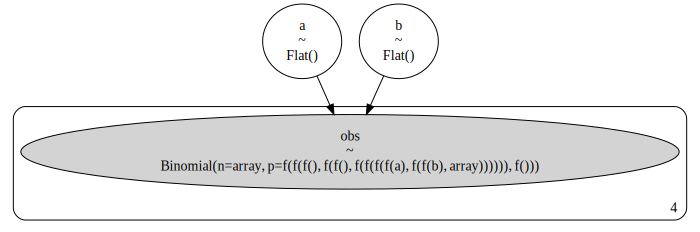

In [50]:
pm.model_to_graphviz(m)


In [67]:
with m:
    model_map = pm.find_MAP()
model_map

{'a': array(0.84657861), 'b': array(7.74880723)}

In [69]:
with m:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [70]:
az.summary(trace)

/home/ricardo/Documents/Projects/pymc3-venv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.303,1.122,-0.726,3.339,0.036,0.027,984.0,889.0,1029.0,1032.0,1.0
b,11.440,5.692,2.731,21.777,0.193,0.136,873.0,873.0,933.0,1379.0,1.0


(-10.0, 40.0)

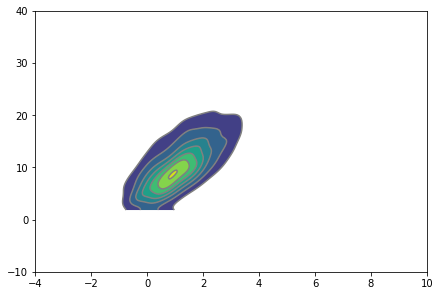

In [75]:
az.plot_kde(trace['a'], trace['b'])
plt.xlim([-4, 10])
plt.ylim([-10, 40])


In [209]:
def compute_logp():
    logp = m.logp
    point = m.test_point

    def compute_logp_(a_, b_):
        point[a] = a_
        point[b] = b_
        return logp(point)

    return compute_logp_
logp = compute_logp()

In [ ]:
mode = np.exp(logp(0.8, 7.7))
mode

In [150]:
a_itvl = np.linspace(-5, 10, 100)
b_itvl = np.linspace(-10, 40, 100)

av, bv = np.meshgrid(a_itvl, b_itvl)
shape = av.shape

lly = np.zeros_like(av).flatten()
av = av.flatten()
bv = bv.flatten()

for i, (a_value, b_value) in enumerate(zip(av, bv)):

    lly[i] = logp(a_value, b_value)

lly = np.exp(lly)
av = av.reshape(shape)
bv = bv.reshape(shape)
lly = lly.reshape(shape)

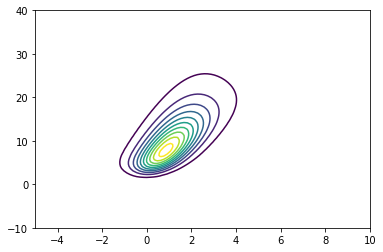

In [162]:
levels = np.arange(.05, .951, .1) * mode
CS = plt.contour(av, bv, lly, levels, origin='lower')
# plt.contour(CS, levels=CS.levels[::], colors='k', origin='lower')

In [155]:
CS.levels

array([5.15017184e-44, 4.20448383e-27, 6.08516362e-15, 6.15734722e-11,
       1.47488311e-08, 1.06087526e-06, 2.31919390e-05, 2.36859905e-04,
       1.92086879e-03, 2.63806545e-02])

In [123]:
lly.shape

(10, 5)

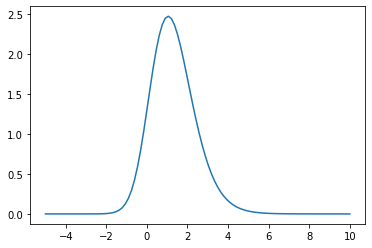

In [152]:
a_marginal = np.sum(lly, axis=0)
plt.plot(a_itvl, a_marginal)

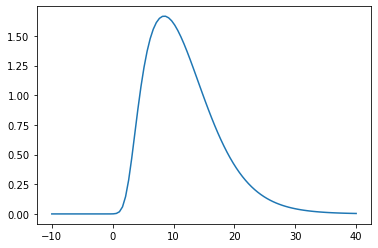

In [163]:
b_marginal = np.sum(lly, axis=1)
plt.plot(b_itvl, b_marginal)


In [305]:
def sample_grid(intervals, model=None):
    model = pm.modelcontext(model)

    bij = pm.DictToArrayBijection(pm.ArrayOrdering(intervals.keys()), model.test_point)
    logp_func = bij.mapf(model.fastlogp_nojac)

    grid = np.meshgrid(*intervals.values())
    grid_shape = grid[0].shape
    lly = np.zeros(grid[0].size)
    grid = (a.flatten() for a in grid)

    for i, variables in enumerate(zip(*grid)):
        lly[i] = logp_func(variables)

    lly = lly.reshape(grid_shape)
    grid = {variable: values.reshape(grid_shape)
            for variable, values in zip(intervals.keys(), grid)}
    return grid, lly

In [306]:
intervals = {
    b: np.linspace(-10, 40, 200),
    a: np.linspace(-5, 10, 100),
}
with m:
    grid, lly = sample_grid(intervals)

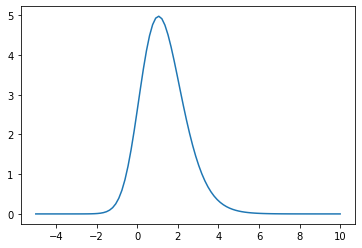

In [307]:
a_marginal = np.sum(np.exp(lly), axis=1)
plt.plot(intervals[a], a_marginal)

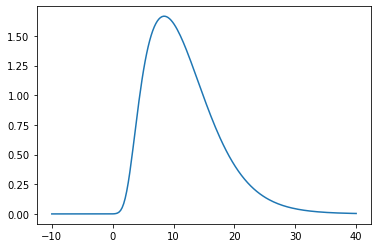

In [308]:
b_marginal = np.sum(np.exp(lly), axis=0)
plt.plot(intervals[b], b_marginal)

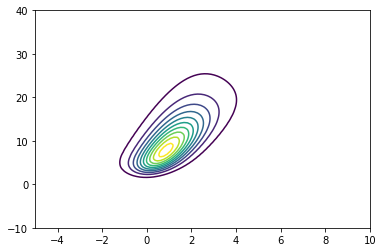

In [309]:
levels = np.arange(.05, .951, .1) * mode
CS = plt.contour(intervals[a], intervals[b], np.exp(lly).T, levels, origin='lower')